###<font color = green>Problem: use daisneyland review and rating data to create a satisfaction rating prediction model based on reviews.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#package needed
#supressing warnings about future changes in Python
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#install modules from inside Jupyter
import sys

import re

import numpy as np

import keras

#Natural Language ToolKit
!{sys.executable} -m pip install nltk
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

!{sys.executable} -m pip install sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer


import matplotlib.pyplot as plt
%matplotlib inline
!{sys.executable} -m pip install pyLDAvis
import pyLDAvis
#import pyLDAvis.sklearn

#html parser for digesting text taken from web-pages
!{sys.executable} -m pip install html.parser
import html.parser
from html.parser import HTMLParser

#handling unicode characters and strings
import unicodedata
import string
!{sys.executable} -m pip install pattern3
import pattern3

from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=d45b3b1baeea96612ce9b80ee072ad87aaa0dca1f3db40b6dfbbda760a6824af
  Stored in directory: /root/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d40970a40c22c472ae50f0a1
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
   

###<font color = green> prepare and preprocess function

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/text mining/final/DisneylandReviews.csv')
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,Apr-19,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,May-19,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,Apr-19,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,Apr-19,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,Apr-19,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
wnl = WordNetLemmatizer()
html_parser = HTMLParser()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#stop words
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list = stopword_list + ['mr', 'mrs', 'come', 'go', 'get',
                                 'tell', 'listen', 'one', 'two', 'three',
                                 'four', 'five', 'six', 'seven', 'eight',
                                 'nine', 'zero', 'join', 'find', 'make',
                                 'say', 'ask', 'tell', 'see', 'try', 'back',
                                 'also','would']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#word tokenization function
nltk.download('punkt')

def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#world contraction
contraction_mapping = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#expand contraction function
def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#annotate text tokens with Part-Of-Speach tags
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def pos_tag_text(text_tokens):
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None  
    tagged_text = nltk.pos_tag(text_tokens)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag)) for word, pos_tag in tagged_text]
    return tagged_lower_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#lematization
def lemmatize_text(text):
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag else word for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#remove special characters
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#stopwords
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#remove non-text characters
def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#remove html
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)
    
def strip_html(text):
    html_stripper = MLStripper()
    html_stripper.feed(text)
    return html_stripper.get_data()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#decode
def normalize_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf8')
    return text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def normalize_text(text): 
  text = normalize_accented_characters(text)
  text = html.unescape(text)
  text = strip_html(text)
  text = expand_contractions(text, contraction_mapping)
  text = tokenize_text(text)
  text = lemmatize_text(text)
  text = remove_special_characters(text)
  text = remove_stopwords(text)
  text = keep_text_characters(text)    
  return text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###<font color = green> preprocess the data

In [ ]:
df["review"] = df["Review_Text"].apply(normalize_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_pro = df[df["Year_Month"] != "missing"]
df_pro["Year"] = df_pro["Year_Month"].str[-2:]
df_pro = df_pro[df_pro["Year"].astype(int) >= 15]
df_pro['Year'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-0dbca4b9b18a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pro["Year"] = df_pro["Year_Month"].str[-2:]


15    6979
16    6599
17    5195
18    3997
19     786
Name: Year, dtype: int64

In [ ]:
df_pro.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Review_ID             int64
Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
review               object
Year                 object
dtype: object

###<font color = green>Based on rating make sample

In [ ]:
df_pro['Rating'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    12828
4     5910
3     2842
2     1159
1      817
Name: Rating, dtype: int64

In [ ]:
# stratified sampling
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['Review_Text'], df['Rating'], test_size=0.3, stratify=df['Rating'], random_state=114514)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###<font color = green>Preparing the dataset for Deep Learning Models

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#initialize parameters
max_words = 11451 
maxlen = 114 
#batch_size = 32

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#tokenize
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test)

print(len(X_train))
print(len(X_test))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


29859
12797


In [ ]:
#pad_sequence
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X_train shape: (29859, 114)
X_test shape: (12797, 114)


In [ ]:
X_train_df = pd.DataFrame(X_train)
X_train_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(29859, 114)

###<font color = green> Build the moodel with cnn and lstm

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D 
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(layers.Bidirectional(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 114, 128)          1465728   
                                                                 
 conv1d_3 (Conv1D)           (None, 110, 128)          82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, 27, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                      

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics='mape')
model.fit(X_train, y_train, epochs=30, batch_size=48, validation_data=(X_test,y_test))

keras.backend.clear_session

Epoch 1/30
623/623 [==============================] - 322s 499ms/step - loss: 0.6380 - mape: 24.3768 - val_loss: 0.5271 - val_mape: 20.5065
Epoch 2/30
623/623 [==============================] - 322s 517ms/step - loss: 0.4816 - mape: 17.8959 - val_loss: 0.5164 - val_mape: 19.5045
Epoch 3/30
623/623 [==============================] - 326s 523ms/step - loss: 0.4332 - mape: 15.9681 - val_loss: 0.5147 - val_mape: 18.5233
Epoch 4/30
623/623 [==============================] - 322s 516ms/step - loss: 0.4013 - mape: 14.4997 - val_loss: 0.5415 - val_mape: 17.9765
Epoch 5/30
623/623 [==============================] - 306s 491ms/step - loss: 0.3765 - mape: 13.2764 - val_loss: 0.5026 - val_mape: 18.5540
Epoch 6/30
623/623 [==============================] - 325s 523ms/step - loss: 0.3403 - mape: 11.8046 - val_loss: 0.5187 - val_mape: 18.0228
Epoch 7/30
623/623 [==============================] - 303s 486ms/step - loss: 0.3172 - mape: 10.7706 - val_loss: 0.5041 - val_mape: 18.5727
Epoch 8/30
623/623 [

<function keras.backend.clear_session()>

In [ ]:
del model

###<font color = green>fit another one with larger max_len and batch size

In [ ]:
max_words = 11451 
maxlen = 200 
#batch_size = 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test)

print(len(X_train))
print(len(X_test))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


29859
12797


In [ ]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X_train shape: (29859, 200)
X_test shape: (12797, 200)


In [ ]:
X_train_df = pd.DataFrame(X_train)
X_train_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(29859, 200)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D 
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(layers.Bidirectional(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(1))

model.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1465728   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 49, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                        

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics='mape')
model2 = model.fit(X_train, y_train, epochs=35, batch_size=72, validation_data=(X_test,y_test))

keras.backend.clear_session

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/35
415/415 [==============================] - 527s 1s/step - loss: 0.6560 - mape: 24.8848 - val_loss: 0.5080 - val_mape: 19.3475
Epoch 2/35
415/415 [==============================] - 501s 1s/step - loss: 0.4651 - mape: 17.0667 - val_loss: 0.5106 - val_mape: 17.8592
Epoch 3/35
415/415 [==============================] - 492s 1s/step - loss: 0.4169 - mape: 15.2789 - val_loss: 0.4890 - val_mape: 17.4821
Epoch 4/35
415/415 [==============================] - 484s 1s/step - loss: 0.3769 - mape: 13.6321 - val_loss: 0.4733 - val_mape: 18.0601
Epoch 5/35
415/415 [==============================] - 495s 1s/step - loss: 0.3532 - mape: 12.6930 - val_loss: 0.4838 - val_mape: 18.9186
Epoch 6/35
415/415 [==============================] - 492s 1s/step - loss: 0.3255 - mape: 11.6457 - val_loss: 0.4730 - val_mape: 17.1128
Epoch 7/35
415/415 [==============================] - 496s 1s/step - loss: 0.3033 - mape: 10.6851 - val_loss: 0.4751 - val_mape: 17.8183
Epoch 8/35
415/415 [=====================

<function keras.backend.clear_session()>

###<font color = green>It seems that we get a better model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


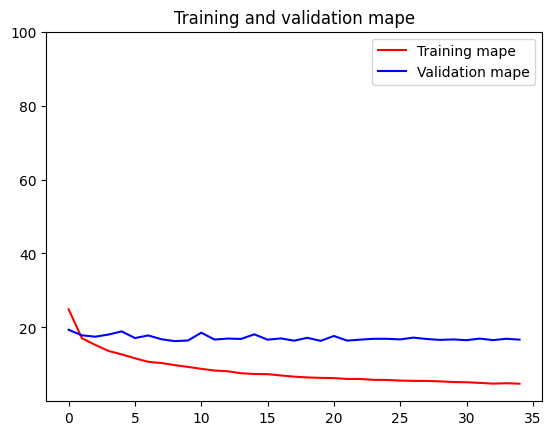

In [ ]:
mape = model2.history['mape']
val_mape = model2.history['val_mape']
loss = model2.history['loss']
val_loss = model2.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

###<font color = green> Check the measurements

In [ ]:
y_pred = model.predict(X_test)
y_pred_cat = np.round(y_pred).astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


400/400 [==============================] - 50s 124ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_cat)
precision = precision_score(y_test, y_pred_cat, average='weighted')
recall = recall_score(y_test, y_pred_cat, average='weighted')
f1 = f1_score(y_test, y_pred_cat, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.5891224505743534
Precision: 0.5797528686983552
Recall: 0.5891224505743534
F1-score: 0.5837756917527693


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
